## Further Model Tuning with PCA

Because of the focus on model performance and the inclusion of many engineered features in the base dataset, I believed it to be beneficial to attempt Princpal Component Analysis on the variables in order to find strong linear correlation with the target and minimize colinearity as much as possible.

#### Imports

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingRegressor

pd.set_option('display.max_rows', None)

In [4]:
df = pd.read_csv('./data/working_data.csv')
df.shape

(26955, 142)

#### Dropping Object types and One-Hot coded variables

In [5]:
# dropping objects and itentyfier variables
df.drop(df.select_dtypes(exclude='number').columns.tolist(), axis=1, inplace=True)

df.drop(['year', 'fips_code'], axis=1, inplace=True)

In [6]:
# dropping all one-hot coded variables
columns = df.columns.tolist()
mean_less_one = [col for col in columns if df[col].mean()<1]
binary = [col for col in mean_less_one if df[col].dtype == 'int64']
df.drop(binary, axis=1, inplace=True)

#### Transforming 

In [7]:
# creating a list of features to use
features_list = df.drop(['pcpv'], axis=1).columns.tolist()
print(f'There are NOW {len(features_list)} features:','\n')
print(features_list)

There are NOW 128 features: 

['num_nurses', 'num_home_health_agents', 'num_hospices', 'pop_est', 'vet_pop_est', 'num_qualify_medicare', 'unemploy_rate', 'num_docs_male', 'num_docs_fem', 'num_docs_under35', 'num_docs_35-44', 'num_docs_45-54', 'num_docs_55-64', 'num_docs_65-74', 'num_docs_75above', 'num_specialists_under35', 'num_specialists_35-44', 'num_specialists_45-54', 'num_specialists_55-64', 'num_specialists_65-74', 'num_specialists_75above', 'num_dents_under35', 'num_dents_35-44', 'num_dents_45-54', 'num_dents_55-64', 'num_dents_65above', 'num_hos_beds', 'num_short_term_gen_beds', 'num_short_term_nongen_beds', 'num_long_term_beds', 'num_nursehome_beds', 'num_inpatient_days', 'num_veteran_outpat_vists', 'per_cap_medicare_cost', 'tot_male_pop', 'tot_fem_pop', 'tot_white_male_pop', 'tot_white_fem_pop', 'tot_black_male_pop', 'tot_black_fem_pop', 'tot_asian_male_pop', 'tot_asian_fem_pop', 'tot_hispanic_male_pop', 'tot_hispanic_fem_pop', 'num_has_medicare', 'num_deaths_any', 'per_cap_

In [8]:
# makeing a pipeline to transform data of these features
feature_pipeline = Pipeline(steps=[
    ('scale', StandardScaler())
])

In [9]:
# ColumnTransformer applies this pipline to the features in the feature list
feature_processor = ColumnTransformer(transformers=[
    ('features', feature_pipeline, features_list)
])

#### Making X and y

In [10]:
X = df.drop('pcpv', axis=1)
y = df['pcpv']

In [11]:
X.shape, y.shape

((26955, 128), (26955,))

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state = 42)

#### Polynominal Features

- **NOTE** this was scrapped due to the technical issues it caused the local machine running the coputations.

In [13]:
poly = PolynomialFeatures(include_bias = False)

In [14]:
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

In [15]:
X_train_poly.shape, X_test_poly.shape

((21564, 8384), (5391, 8384))

#### PCA

In [16]:
# instanciate the model and PCA
gb = GradientBoostingRegressor()
pca = PCA()

# make a pike that processes the features, applies PCA,
# and runs the features through the model
gb_pipe = Pipeline(steps=[
    ('preprocesser', feature_processor),
    ('pca', pca),
    ('model', gb)
])

In [18]:
# create a parameter grid to search through for 
# best model parameters
gbr_params = {
    'model__max_depth': [3, 5, 7],
    'model__n_estimators': [150, 200, 250],
    'model__random_state': [42]
}

search = GridSearchCV(gb_pipe, gbr_params, n_jobs=-1)
search.fit(X_train, y_train)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Best parameter (CV score=0.859):
{'model__max_depth': 7, 'model__n_estimators': 250, 'model__random_state': 42}


In [19]:
# instantiate another model with those best params
gbr_best_params = GradientBoostingRegressor(max_depth=7, 
                                            n_estimators=250, 
                                            random_state=42) 

In [20]:
pca.fit(feature_processor.fit_transform(X_train))

PCA()

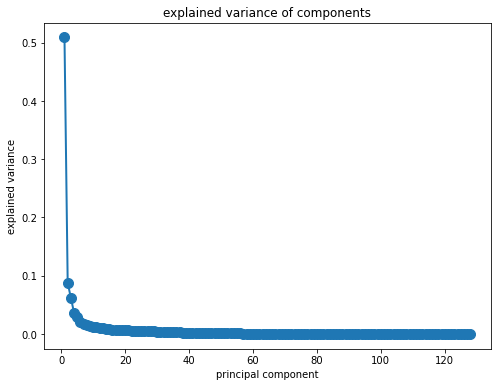

In [21]:
# graph the explained variance of each principal component
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(range(1,129), pca.explained_variance_ratio_, lw=2)
ax.scatter(range(1,129), pca.explained_variance_ratio_, s=100)
ax.set_title('explained variance of components')
ax.set_xlabel('principal component')
ax.set_ylabel('explained variance');

In [22]:
# find the r2 (explained variance) of the first 5 principle components
sum(pca.explained_variance_ratio_[:5])

0.7242826957755718

In [23]:
# create a dataframe for all those components and their weights
pca_df = pd.DataFrame(pca.transform(feature_processor.fit_transform(X_train)),
                      columns=['pr_comp_' + str(i) for i in range(feature_processor.fit_transform(X_train).shape[1])])
pca_df.head()

,pr_comp_0,pr_comp_1,pr_comp_2,pr_comp_3,pr_comp_4,pr_comp_5,pr_comp_6,pr_comp_7,pr_comp_8,pr_comp_9,...,pr_comp_118,pr_comp_119,pr_comp_120,pr_comp_121,pr_comp_122,pr_comp_123,pr_comp_124,pr_comp_125,pr_comp_126,pr_comp_127
0,4.489411,2.245589,0.519719,4.706906,-0.069321,-0.067994,-1.983315,-0.347133,-1.441217,-0.495367,...,0.004297,0.004281,0.000470,-0.000080,0.004159,0.000293,1.430879e-15,2.025620e-15,9.139092e-16,-3.026657e-16
1,-1.742206,0.880160,2.757237,1.624242,-1.293919,-0.263109,-0.453939,-1.127777,-1.338731,0.353491,...,0.000050,-0.002154,-0.000091,0.000643,-0.000048,0.000043,2.079972e-15,-9.405359e-16,-5.666735e-16,1.322638e-15
2,22.291113,5.207223,-0.073782,-4.555249,2.116003,4.561889,0.183529,0.862932,-3.377929,1.582900,...,0.001395,0.014860,0.002615,0.000326,-0.001408,0.000399,-2.520967e-15,-3.026868e-15,2.132211e-15,-3.249330e-15
3,0.763224,-0.270487,-4.411939,0.393369,0.859406,-0.104322,-1.007155,-0.012768,-1.366362,-0.729551,...,-0.001109,0.006938,0.000206,-0.000137,-0.000115,0.000011,-1.924932e-16,8.753049e-17,-8.787962e-16,-1.075741e-15
4,-2.256100,-0.521590,-3.472364,-0.177844,0.717064,-0.435285,2.790334,1.679138,1.441469,0.397381,...,0.000408,0.000285,0.000447,-0.000620,-0.000100,0.000097,-1.197516e-15,-2.539517e-15,6.193168e-16,-5.661700e-16


In [24]:
pca_df['pcpv'] = list(y_train)

In [25]:
# evaluate the principle components with the best params model
scores = cross_val_score(gbr_best_params,
                         pca_df.iloc[:, :20],
                         pca_df.iloc[:, -1],
                         cv=KFold(n_splits=5,
                                  shuffle=True,
                                  random_state=73))

round(scores.mean(), 2), '+-', round(2 * scores.std(), 2)

(0.73, '+-', 0.02)

#### Conclusionn

- Was able to perform PCA on the large amount of variables included in the dataset but unfortunetly was unable to interpret which variables explained the most variance in the model
- Evaluated model performed better than previous Gradient Boosted decision tree model with manually selected features.

In [26]:
# combine coeff values and description
# based off of GridSearches best estimates
# importance_val = search.best_estimator_.named_steps.model.feature_importances_
# importance_df = pd.DataFrame({'features': np.array(features_list), 'importance_val': np.array(importance_val)}, columns=['features', 'importance'])
# importance_df.head()
# importance_df.sort_values(by = 'importance_val', ascending  = False)[:10]
